# Image Comparison (Epipolar Anomaly Detection)

This notebook compares a **reference** image (time 1) against a **new** image (time 2) of the same scene
**from different viewpoints**. It uses **epipolar geometry** to rectify the pair, computes dense
correspondence along epipolar lines, and flags regions that **cannot be matched** as potential anomalies.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (relative to this notebook)
REFERENCE_PATH = Path('IMG_4356.jpg')
NEW_PATH = Path('IMG_4358.jpg')

# Tuning knobs
MAX_DIM = 1200  # resize for speed (pixels on longest side); set None to disable
MIN_REGION_AREA = 200  # pixels (after resizing); filters small noise
MATCH_RATIO = 0.75  # Lowe's ratio for feature matching
RANSAC_REPROJ = 1.5  # px, for fundamental matrix estimation
Z_THRESHOLD = 3.0  # robust z-score threshold for anomaly mask

# Camera intrinsics (optional). If None, approximate from image size.
INTRINSICS = None  # e.g. np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)
FOCAL_SCALE = 1.2  # used when INTRINSICS is None; fx=fy=FOCAL_SCALE*max(w,h)


# Disparity / consistency settings
CONSISTENCY_THRESH = 1.0  # px, left-right disparity consistency
TEXTURE_PERCENTILE = 60  # only consider textured areas for occlusion anomalies

# Stereo SGBM parameters (auto num disparities if None)
SGBM_BLOCK_SIZE = 5
SGBM_NUM_DISPARITIES = None  # must be multiple of 16; None = auto
SGBM_MAX_NUM_DISPARITIES = 192

print('Reference:', REFERENCE_PATH.resolve())
print('New:      ', NEW_PATH.resolve())


Reference: /Users/macbook/Documents/Innowing/ImageComparison/IMG_4356.jpg
New:       /Users/macbook/Documents/Innowing/ImageComparison/IMG_4358.jpg


In [6]:
def read_bgr(path):
    if not path.exists():
        raise FileNotFoundError(f'Missing image: {path.resolve()}')
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f'Failed to read image: {path.resolve()}')
    return img


def resize_max_dim(bgr, max_dim):
    if max_dim is None:
        return bgr
    h, w = bgr.shape[:2]
    scale = max_dim / max(h, w)
    if scale >= 1.0:
        return bgr
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    return cv2.resize(bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)


def preprocess_gray(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray


def detect_and_match(gray1, gray2, ratio=MATCH_RATIO):
    try:
        detector = cv2.SIFT_create()
        norm = cv2.NORM_L2
        method = 'SIFT'
    except Exception:
        detector = cv2.ORB_create(nfeatures=4000)
        norm = cv2.NORM_HAMMING
        method = 'ORB'

    kp1, des1 = detector.detectAndCompute(gray1, None)
    kp2, des2 = detector.detectAndCompute(gray2, None)
    if des1 is None or des2 is None or len(kp1) < 8 or len(kp2) < 8:
        raise RuntimeError('Not enough features to estimate epipolar geometry.')

    bf = cv2.BFMatcher(norm)
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)

    if len(good) < 8:
        raise RuntimeError('Not enough good matches for fundamental matrix estimation.')

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])
    return pts1, pts2, method, kp1, kp2, good


def estimate_fundamental(pts1, pts2, reproj=RANSAC_REPROJ):
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, reproj, 0.99)
    if F is None or mask is None:
        raise RuntimeError('Fundamental matrix estimation failed.')
    inliers = mask.ravel().astype(bool)
    if inliers.sum() < 8:
        raise RuntimeError('Not enough inliers after RANSAC.')
    return F, pts1[inliers], pts2[inliers]


def rectify_uncalibrated(img1, img2, pts1, pts2, F):
    h, w = img1.shape[:2]
    ok, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imgSize=(w, h))
    if not ok:
        raise RuntimeError('Rectification failed.')
    rect1 = cv2.warpPerspective(img1, H1, (w, h))
    rect2 = cv2.warpPerspective(img2, H2, (w, h))
    return rect1, rect2, H1, H2


def compute_overlap_mask(shape1, shape2, H1, H2, out_size):
    h, w = out_size
    mask1 = np.full(shape1, 255, dtype=np.uint8)
    mask2 = np.full(shape2, 255, dtype=np.uint8)
    rect_mask1 = cv2.warpPerspective(mask1, H1, (w, h), flags=cv2.INTER_NEAREST)
    rect_mask2 = cv2.warpPerspective(mask2, H2, (w, h), flags=cv2.INTER_NEAREST)
    overlap = (rect_mask1 > 0) & (rect_mask2 > 0)
    return overlap.astype(np.uint8) * 255


def compute_disparity(left_gray, right_gray, num_disparities, block_size):
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * block_size * block_size,
        P2=32 * block_size * block_size,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )
    disp = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp


def gradient_magnitude(gray):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx * gx + gy * gy)


def find_regions(mask_u8, min_area):
    contours, _hier = cv2.findContours(mask_u8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    for c in contours:
        area = float(cv2.contourArea(c))
        if area < float(min_area):
            continue
        x, y, w, h = cv2.boundingRect(c)
        regions.append((x, y, w, h, area))
    regions.sort(key=lambda r: r[4], reverse=True)
    return regions


def bgr_to_rgb(bgr):
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def overlay_prob(base_bgr, prob, color=(0, 0, 255), min_alpha=0.15, max_alpha=0.75):
    prob = np.clip(prob, 0, 1)
    alpha = min_alpha + (max_alpha - min_alpha) * prob
    alpha = alpha * (prob > 0)
    alpha_3 = alpha[..., None]

    base = base_bgr.astype(np.float32)
    color_layer = np.zeros_like(base)
    color_layer[:] = color

    blended = base * (1.0 - alpha_3) + color_layer * alpha_3
    return blended.clip(0, 255).astype(np.uint8)


def get_camera_matrix(width, height, intrinsics, f_scale):
    if intrinsics is not None:
        K = np.asarray(intrinsics, dtype=np.float64)
        if K.shape != (3, 3):
            raise ValueError('INTRINSICS must be a 3x3 matrix')
        return K
    f = float(f_scale) * float(max(width, height))
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    return np.array([[f, 0.0, cx], [0.0, f, cy], [0.0, 0.0, 1.0]], dtype=np.float64)


def enforce_essential_matrix(E):
    U, _S, Vt = np.linalg.svd(E)
    return U @ np.diag([1.0, 1.0, 0.0]) @ Vt


def estimate_pose_from_fundamental(F, pts1, pts2, K):
    E = K.T @ F @ K
    E = enforce_essential_matrix(E)
    pts1 = pts1.reshape(-1, 1, 2)
    pts2 = pts2.reshape(-1, 1, 2)
    retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    if mask is None:
        mask = np.ones((pts1.shape[0], 1), dtype=np.uint8)
    inliers = mask.ravel().astype(bool)
    return E, R, t, inliers, int(retval)


def rotation_to_axis_angle(R):
    rvec, _ = cv2.Rodrigues(R)
    rvec = rvec.reshape(-1)
    angle = float(np.linalg.norm(rvec))
    if angle < 1e-9:
        axis = np.array([0.0, 0.0, 1.0], dtype=np.float64)
    else:
        axis = rvec / angle
    return rvec, np.degrees(angle), axis


def rotation_matrix_to_euler_zyx(R):
    # ZYX convention: yaw (Z), pitch (Y), roll (X)
    sy = float(np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0]))
    singular = sy < 1e-6
    if not singular:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[0, 1], R[1, 1])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = 0.0
    return np.degrees(yaw), np.degrees(pitch), np.degrees(roll)


def rotation_homography(K, R, to_reference=True):
    # If R maps reference -> new, use R.T to rotate new -> reference
    R_use = R.T if to_reference else R
    return K @ R_use @ np.linalg.inv(K)


def warp_by_rotation(image_bgr, K, R, out_size):
    H = rotation_homography(K, R, to_reference=True)
    return cv2.warpPerspective(image_bgr, H, out_size)

def overlay_binary(base_bgr, mask_bool, color=(0, 0, 255), alpha=0.6):
    mask = mask_bool.astype(bool)
    out = base_bgr.copy()
    if not mask.any():
        return out
    overlay = np.zeros_like(out)
    overlay[:] = color
    out[mask] = (out[mask] * (1.0 - alpha) + overlay[mask] * alpha).astype(np.uint8)
    return out


def draw_epiline(img, line, color, thickness=1):
    a, b, c = line
    h, w = img.shape[:2]
    if abs(a) < 1e-12 and abs(b) < 1e-12:
        return img
    if abs(b) > abs(a):
        x0, y0 = 0, int(round(-c / b))
        x1, y1 = w - 1, int(round(-(c + a * (w - 1)) / b))
    else:
        y0, x0 = 0, int(round(-c / a))
        y1, x1 = h - 1, int(round(-(c + b * (h - 1)) / a))

    x0 = int(np.clip(x0, 0, w - 1))
    x1 = int(np.clip(x1, 0, w - 1))
    y0 = int(np.clip(y0, 0, h - 1))
    y1 = int(np.clip(y1, 0, h - 1))
    return cv2.line(img, (x0, y0), (x1, y1), color, thickness)


def draw_epipolar_matches(img1, img2, pts1, pts2, F, max_pairs=20, seed=0):
    if len(pts1) == 0 or len(pts2) == 0:
        return img1.copy(), img2.copy()

    rng = np.random.default_rng(seed)
    idx = np.arange(len(pts1))
    if len(idx) > max_pairs:
        idx = rng.choice(idx, size=max_pairs, replace=False)

    pts1_s = pts1[idx]
    pts2_s = pts2[idx]

    lines1 = cv2.computeCorrespondEpilines(pts2_s.reshape(-1, 1, 2), 2, F)
    lines2 = cv2.computeCorrespondEpilines(pts1_s.reshape(-1, 1, 2), 1, F)
    lines1 = lines1.reshape(-1, 3)
    lines2 = lines2.reshape(-1, 3)

    img1_out = img1.copy()
    img2_out = img2.copy()
    colors = rng.integers(0, 255, size=(len(idx), 3))

    for pt1, pt2, l1, l2, col in zip(pts1_s, pts2_s, lines1, lines2, colors):
        color = (int(col[0]), int(col[1]), int(col[2]))
        img1_out = draw_epiline(img1_out, l1, color, 1)
        img2_out = draw_epiline(img2_out, l2, color, 1)
        img1_out = cv2.circle(img1_out, tuple(np.int32(pt1)), 4, color, -1)
        img2_out = cv2.circle(img2_out, tuple(np.int32(pt2)), 4, color, -1)

    return img1_out, img2_out


Feature method: SIFT, matches: 26, inliers: 15


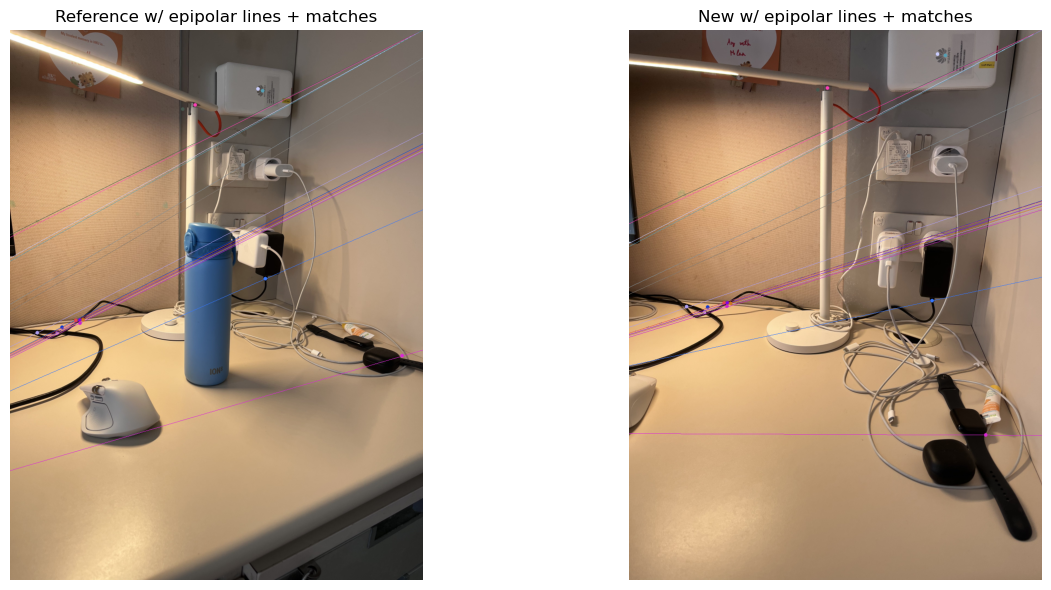

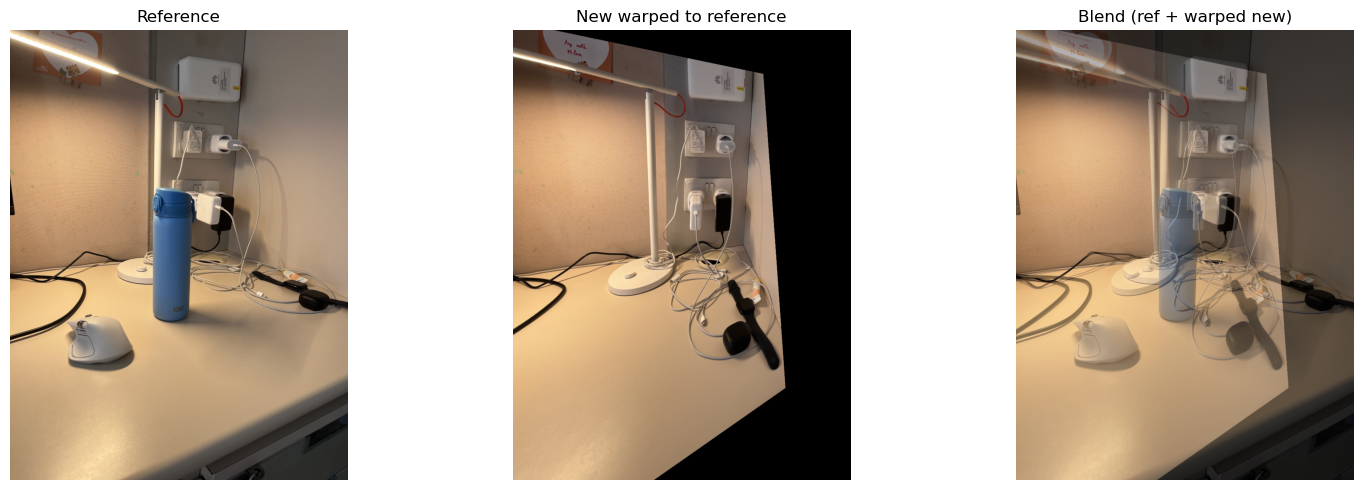

Disparity: num_disp=128, valid_px=209673 / 1080000
Absent in new (ref->new, texture-filtered): 75861
Present in new (new->ref, texture-filtered): 101482
Regions (area >= 200px): 58


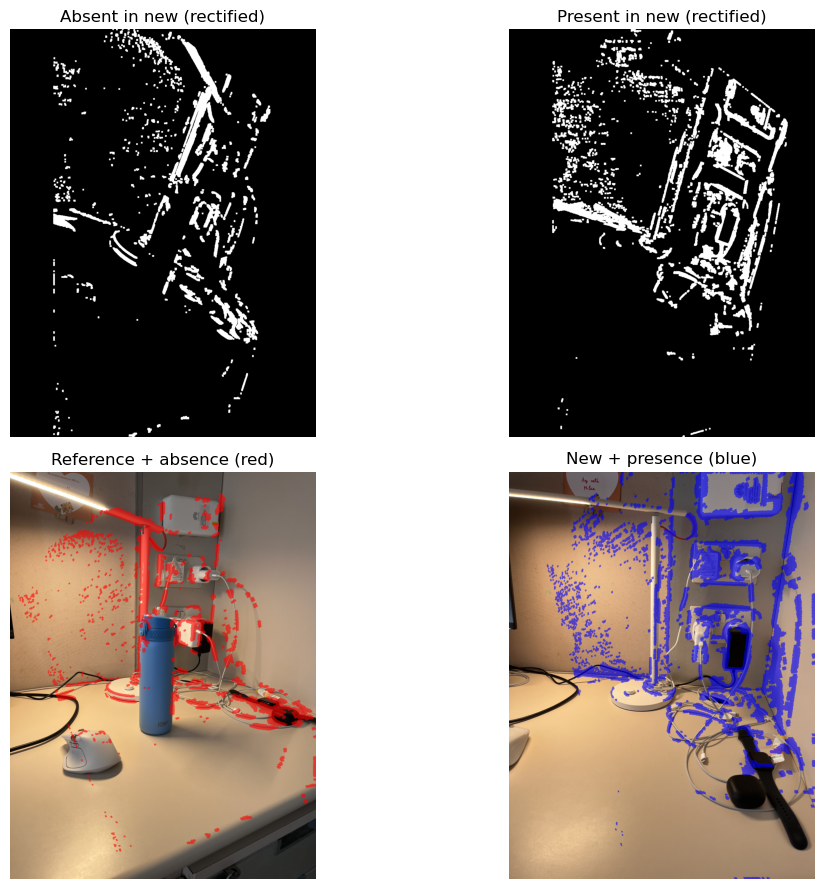

Region 1: x=377, y=18, w=246, h=642, area=21937px
Region 2: x=527, y=476, w=162, h=231, area=13986px
Region 3: x=434, y=695, w=296, h=230, area=13604px
Region 4: x=544, y=277, w=197, h=208, area=12262px
Region 5: x=127, y=475, w=272, h=201, area=11004px
Region 6: x=624, y=131, w=160, h=195, area=8358px
Region 7: x=670, y=448, w=89, h=356, area=7020px
Region 8: x=358, y=0, w=121, h=106, area=2420px
Region 9: x=573, y=451, w=131, h=82, area=2354px
Region 10: x=762, y=263, w=58, h=158, area=2164px
Saved rectified views and anomaly overlays to disk.


In [7]:
# 1) Load images
ref_bgr = read_bgr(REFERENCE_PATH)
new_bgr = read_bgr(NEW_PATH)

# 2) Optional resize for faster processing
ref_bgr = resize_max_dim(ref_bgr, MAX_DIM)
new_bgr = resize_max_dim(new_bgr, MAX_DIM)

# 3) Detect/match features and estimate the fundamental matrix
ref_gray = preprocess_gray(ref_bgr)
new_gray = preprocess_gray(new_bgr)

pts1, pts2, method, kp1, kp2, good = detect_and_match(ref_gray, new_gray)
F, pts1_in, pts2_in = estimate_fundamental(pts1, pts2)
print(f'Feature method: {method}, matches: {len(good)}, inliers: {len(pts1_in)}')

# 1) Epipolar lines + matching points (visual check)
epi_ref, epi_new = draw_epipolar_matches(ref_bgr, new_bgr, pts1_in, pts2_in, F, max_pairs=24, seed=7)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(bgr_to_rgb(epi_ref)); axes[0].set_title('Reference w/ epipolar lines + matches'); axes[0].axis('off')
axes[1].imshow(bgr_to_rgb(epi_new)); axes[1].set_title('New w/ epipolar lines + matches'); axes[1].axis('off')
plt.tight_layout()
plt.show()

# 2) Warp one picture onto the other using matching points (homography)
H_h, H_mask = cv2.findHomography(pts2_in, pts1_in, cv2.RANSAC, 3.0)
if H_h is None:
    raise RuntimeError('Homography estimation failed.')

warped_new = cv2.warpPerspective(new_bgr, H_h, (ref_bgr.shape[1], ref_bgr.shape[0]))
warp_blend = cv2.addWeighted(ref_bgr, 0.5, warped_new, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(bgr_to_rgb(ref_bgr)); axes[0].set_title('Reference'); axes[0].axis('off')
axes[1].imshow(bgr_to_rgb(warped_new)); axes[1].set_title('New warped to reference'); axes[1].axis('off')
axes[2].imshow(bgr_to_rgb(warp_blend)); axes[2].set_title('Blend (ref + warped new)'); axes[2].axis('off')
plt.tight_layout()
plt.show()

# 3) Rectify both images so epipolar lines become horizontal
rect1, rect2, H1, H2 = rectify_uncalibrated(ref_bgr, new_bgr, pts1_in, pts2_in, F)
rect1_gray = preprocess_gray(rect1)
rect2_gray = preprocess_gray(rect2)

# Overlap mask (to ignore invalid black borders)
h, w = rect1_gray.shape
overlap_u8 = compute_overlap_mask(ref_bgr.shape[:2], new_bgr.shape[:2], H1, H2, (h, w))
overlap = overlap_u8 > 0

# 4) Dense correspondence via stereo disparity (epipolar matching)
if SGBM_NUM_DISPARITIES is None:
    num_disp = max(16, ((w // 8) // 16 + 1) * 16)
    num_disp = min(num_disp, SGBM_MAX_NUM_DISPARITIES)
else:
    num_disp = int(SGBM_NUM_DISPARITIES)
    num_disp = max(16, (num_disp // 16) * 16)

disp12 = compute_disparity(rect1_gray, rect2_gray, num_disp, SGBM_BLOCK_SIZE)
disp21 = compute_disparity(rect2_gray, rect1_gray, num_disp, SGBM_BLOCK_SIZE)

valid12 = (disp12 > 0) & overlap
valid21 = (disp21 > 0) & overlap

# 5) Left-right consistency check (both directions)
xs, ys = np.meshgrid(np.arange(w), np.arange(h))

# ref -> new
x2 = (xs - disp12).round().astype(np.int32)
in_bounds12 = (x2 >= 0) & (x2 < w)

disp21_at = np.zeros_like(disp12)
valid21_at = np.zeros_like(valid12)
disp21_at[in_bounds12] = disp21[ys[in_bounds12], x2[in_bounds12]]
valid21_at[in_bounds12] = valid21[ys[in_bounds12], x2[in_bounds12]]

consistency12 = np.abs(disp12 + disp21_at)
inconsistent12 = valid12 & in_bounds12 & (~valid21_at | (consistency12 > CONSISTENCY_THRESH))

# new -> ref
x1 = (xs - disp21).round().astype(np.int32)
in_bounds21 = (x1 >= 0) & (x1 < w)

disp12_at = np.zeros_like(disp21)
valid12_at = np.zeros_like(valid21)
disp12_at[in_bounds21] = disp12[ys[in_bounds21], x1[in_bounds21]]
valid12_at[in_bounds21] = valid12[ys[in_bounds21], x1[in_bounds21]]

consistency21 = np.abs(disp21 + disp12_at)
inconsistent21 = valid21 & in_bounds21 & (~valid12_at | (consistency21 > CONSISTENCY_THRESH))

# 6) Texture masks to avoid false positives in flat regions
grad1 = gradient_magnitude(rect1_gray)
grad2 = gradient_magnitude(rect2_gray)
if overlap.any():
    tex_thresh1 = np.percentile(grad1[overlap], TEXTURE_PERCENTILE)
    tex_thresh2 = np.percentile(grad2[overlap], TEXTURE_PERCENTILE)
else:
    tex_thresh1 = np.percentile(grad1, TEXTURE_PERCENTILE)
    tex_thresh2 = np.percentile(grad2, TEXTURE_PERCENTILE)

texture1 = grad1 >= tex_thresh1
texture2 = grad2 >= tex_thresh2

# 7) Absence / presence anomalies
absent_mask = inconsistent12 & texture1
present_mask = inconsistent21 & texture2

absent_u8 = (absent_mask.astype(np.uint8) * 255)
present_u8 = (present_mask.astype(np.uint8) * 255)

kernel = np.ones((3, 3), np.uint8)
absent_u8 = cv2.morphologyEx(absent_u8, cv2.MORPH_OPEN, kernel, iterations=1)
absent_u8 = cv2.morphologyEx(absent_u8, cv2.MORPH_DILATE, kernel, iterations=1)

present_u8 = cv2.morphologyEx(present_u8, cv2.MORPH_OPEN, kernel, iterations=1)
present_u8 = cv2.morphologyEx(present_u8, cv2.MORPH_DILATE, kernel, iterations=1)

mask_u8 = cv2.bitwise_or(absent_u8, present_u8)
regions = find_regions(mask_u8, MIN_REGION_AREA)

print(f'Disparity: num_disp={num_disp}, valid_px={valid12.sum()} / {valid12.size}')
print(f'Absent in new (ref->new, texture-filtered): {int(absent_mask.sum())}')
print(f'Present in new (new->ref, texture-filtered): {int(present_mask.sum())}')
print(f'Regions (area >= {MIN_REGION_AREA}px): {len(regions)}')

# 8) Warp anomaly maps back to original images for visualization
H1_inv = np.linalg.inv(H1)
H2_inv = np.linalg.inv(H2)

absent_on_ref = cv2.warpPerspective(absent_u8, H1_inv, (ref_bgr.shape[1], ref_bgr.shape[0]))
present_on_new = cv2.warpPerspective(present_u8, H2_inv, (new_bgr.shape[1], new_bgr.shape[0]))

overlay_ref = overlay_binary(ref_bgr, absent_on_ref > 0, color=(0, 0, 255), alpha=0.6)
overlay_new = overlay_binary(new_bgr, present_on_new > 0, color=(255, 0, 0), alpha=0.6)

# 9) Visualize absence/presence anomalies
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.ravel()

axes[0].imshow(absent_u8, cmap='gray'); axes[0].set_title('Absent in new (rectified)'); axes[0].axis('off')
axes[1].imshow(present_u8, cmap='gray'); axes[1].set_title('Present in new (rectified)'); axes[1].axis('off')
axes[2].imshow(bgr_to_rgb(overlay_ref)); axes[2].set_title('Reference + absence (red)'); axes[2].axis('off')
axes[3].imshow(bgr_to_rgb(overlay_new)); axes[3].set_title('New + presence (blue)'); axes[3].axis('off')

plt.tight_layout()
plt.show()

# Print top anomaly regions (rectified coordinates)
for i, (x, y, w, h, area) in enumerate(regions[:10], start=1):
    print(f'Region {i}: x={x}, y={y}, w={w}, h={h}, area={area:.0f}px')

# Save artifacts
cv2.imwrite('rectified_ref.png', rect1)
cv2.imwrite('rectified_new.png', rect2)
cv2.imwrite('anomaly_mask_rectified.png', mask_u8)
cv2.imwrite('anomaly_mask_absent_rectified.png', absent_u8)
cv2.imwrite('anomaly_mask_present_rectified.png', present_u8)
cv2.imwrite('anomaly_overlay_ref.png', overlay_ref)
cv2.imwrite('anomaly_overlay_new.png', overlay_new)
print('Saved rectified views and anomaly overlays to disk.')


Camera intrinsics (K):
[[1.440e+03 0.000e+00 4.495e+02]
 [0.000e+00 1.440e+03 5.995e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
Pose inliers: 15 / 15
Rotation angle (deg): 14.70, axis=[0.39552967 0.76226775 0.5123516 ]
Yaw/Z (deg): 8.19, Pitch/Y (deg): 10.77, Roll/X (deg): 6.62
Translation (unit-norm, up to scale): [-0.60680348  0.1501584   0.78053955]
Rotation-compensated mean abs diff: 49.44 (valid pixels: 629337)


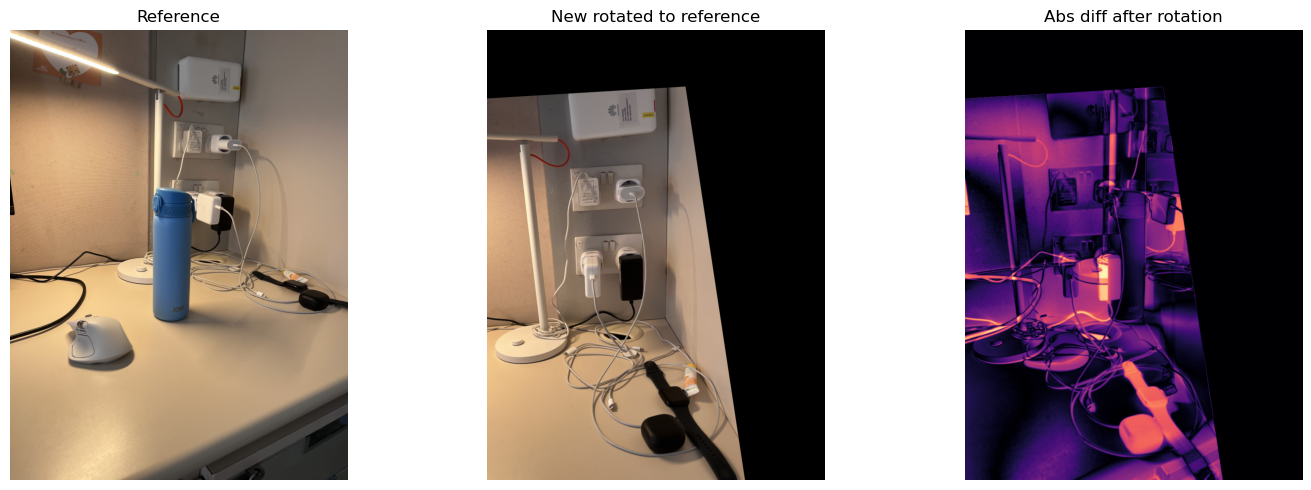

In [8]:
# 3b) Relative pose (rigid transform) + rotation-only alignment
h, w = ref_gray.shape
K = get_camera_matrix(w, h, INTRINSICS, FOCAL_SCALE)
E, R, t, pose_inliers, pose_inlier_count = estimate_pose_from_fundamental(F, pts1_in, pts2_in, K)

rvec, angle_deg, axis = rotation_to_axis_angle(R)
yaw_deg, pitch_deg, roll_deg = rotation_matrix_to_euler_zyx(R)

print('Camera intrinsics (K):')
print(K)
print(f'Pose inliers: {pose_inlier_count} / {len(pose_inliers)}')
print(f'Rotation angle (deg): {angle_deg:.2f}, axis={axis}')
print(f'Yaw/Z (deg): {yaw_deg:.2f}, Pitch/Y (deg): {pitch_deg:.2f}, Roll/X (deg): {roll_deg:.2f}')
print(f'Translation (unit-norm, up to scale): {t.ravel()}')

rotated_new = warp_by_rotation(new_bgr, K, R, (w, h))
rotated_new_gray = preprocess_gray(rotated_new)

# Compare reference vs rotation-compensated new image
valid_mask = cv2.warpPerspective(
    np.full((h, w), 255, dtype=np.uint8),
    rotation_homography(K, R, to_reference=True),
    (w, h),
    flags=cv2.INTER_NEAREST,
)
valid = valid_mask > 0

rot_diff = cv2.absdiff(ref_gray, rotated_new_gray).astype(np.float32)
rot_diff[~valid] = 0
mean_diff = float(rot_diff[valid].mean()) if valid.any() else 0.0
print(f'Rotation-compensated mean abs diff: {mean_diff:.2f} (valid pixels: {int(valid.sum())})')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(bgr_to_rgb(ref_bgr)); axes[0].set_title('Reference'); axes[0].axis('off')
axes[1].imshow(bgr_to_rgb(rotated_new)); axes[1].set_title('New rotated to reference'); axes[1].axis('off')
axes[2].imshow(rot_diff, cmap='magma'); axes[2].set_title('Abs diff after rotation'); axes[2].axis('off')
plt.tight_layout()
plt.show()
